In [273]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from datapackage import Package
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import os
import math
import ast
import re
import string
from dotenv import load_dotenv

In [274]:
load_dotenv("/Users/ivanivsnov/Task_analysis/.env")

PATH_TO_DATA_TASK = os.getenv("PATH_TO_DATA_TASK")

PATH_TO_DATA_EMOJI = os.getenv("PATH_TO_DATA_EMOJI")

In [275]:
# Importing dataset from task
df = pd.read_csv(PATH_TO_DATA_TASK)
# Importing dataset which containes human-maked mood of emojies
df_emojies = pd.read_csv(PATH_TO_DATA_EMOJI)

In [276]:
print(df.isna().sum())

Unnamed: 0           0
created_date         0
url                  0
title              847
language            27
author_name       4574
content              0
language.1          27
host                 0
host_traffic         6
emotion            345
sentiment          176
intent             306
lemmas             221
shares_count      3302
likes_count       3006
hashtags          3021
comments_count    3034
emoticons         4681
country           4719
ave                  0
reach                0
dtype: int64


In [277]:
plt.style.use("seaborn-darkgrid")

/var/folders/w9/xs3lz33j2yg4_7pm0tl8gy080000gn/T/ipykernel_806/1120890811.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [278]:
# Converted "created_date" columns to datetime format
df["created_date"] = pd.to_datetime(df["created_date"])

# Created data for correlation heatmap
df_for_heatmap = df.copy()
df_for_heatmap["day"] = df_for_heatmap["created_date"].dt.day
df_for_heatmap["weekday"] = df_for_heatmap["created_date"].dt.weekday

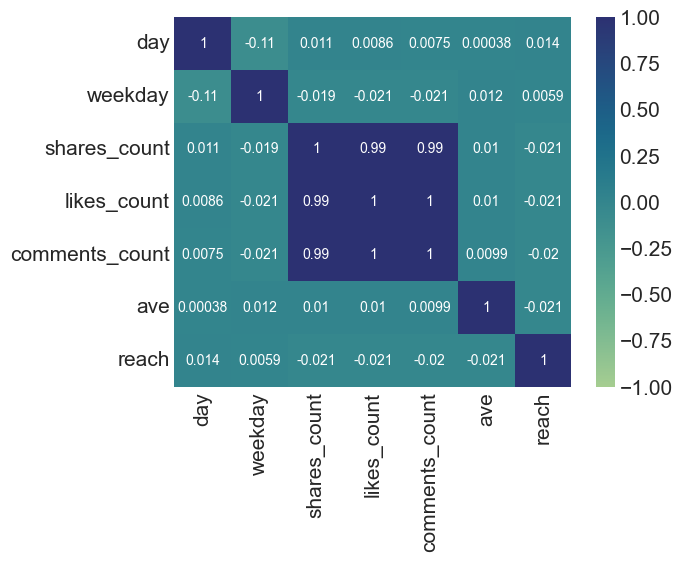

In [279]:
# Just wanted to know if column "ave" correlates with some actions of users
# I assume that due to NaN we can't count Pearson Correlation correctly
df_for_heatmap = df_for_heatmap.loc[
    :, ["day","weekday","shares_count", "likes_count", "comments_count", "ave", "reach"]
]

df_for_heatmap.fillna(0, axis=1, inplace=True)
df_for_heatmap = df_for_heatmap.apply(pd.to_numeric, errors="coerce")

corrs = df_for_heatmap.corr(numeric_only=True, method="pearson")

sns.heatmap(corrs, vmin=-1, vmax=1, annot=True, cmap="crest")
plt.show()

In [280]:
# Language and Language.1 are the same so i can delete one of this columns
print(
    f" The count of same elements is {df[(df['language'].isna() == True) & (df['language.1'].isna() == False)]}"
)

# And also decided to delete index
df.drop(["language.1", "Unnamed: 0"], axis=1, inplace=True)

 The count of same elements is Empty DataFrame
Columns: [Unnamed: 0, created_date, url, title, language, author_name, content, language.1, host, host_traffic, emotion, sentiment, intent, lemmas, shares_count, likes_count, hashtags, comments_count, emoticons, country, ave, reach]
Index: []

[0 rows x 22 columns]


In [281]:
# We have not so much data so we can replace blanck languages/country using other columns
# for example 'content' columns and using detect function detect language

is_nans_of_language = df[df["language"].isna()]

for i in is_nans_of_language.index:
    detect_language = detect(is_nans_of_language.loc[i, "content"])
    df.loc[i, "language"] = detect_language

In [282]:
# I've imported datasets in which every country sign as "PL" corresponds to country(Poland)
# Just to make our plots more visible 
countrues_with_indexes = []
package = Package("https://datahub.io/core/country-list/datapackage.json")

for resource in package.resources:
    if resource.descriptor["datahub"]["type"] == "derived/csv":
        countrues_with_indexes = resource.read()

country_column = []

# If person language is EO -> Esperanto -> he is "wordwide" user
languages_not_in_country = {
    "ZH": "China",
    "CS": "Czech Republic",
    "EN": "Worldwide",
    "SR": "Serbia",
    "EO": "Worldwide",
}

In [283]:
# Simply recreating Country columns('Because' every worker wouldn't understand what really "NL" mean)
# and also check if language exists so the country is the same as a language(better than blank)

language_to_country = {code: country for country, code in countrues_with_indexes}
language_to_country.update(languages_not_in_country)


def update_country(row):
    if ~pd.isna(row["country"]):
        language_code = row["language"].upper()
        mapped_country = language_to_country.get(language_code, row["country"])
        return mapped_country
    else:
        print(mapped_country)
        return "Blank"

df["country"] = df.apply(update_country, axis=1)

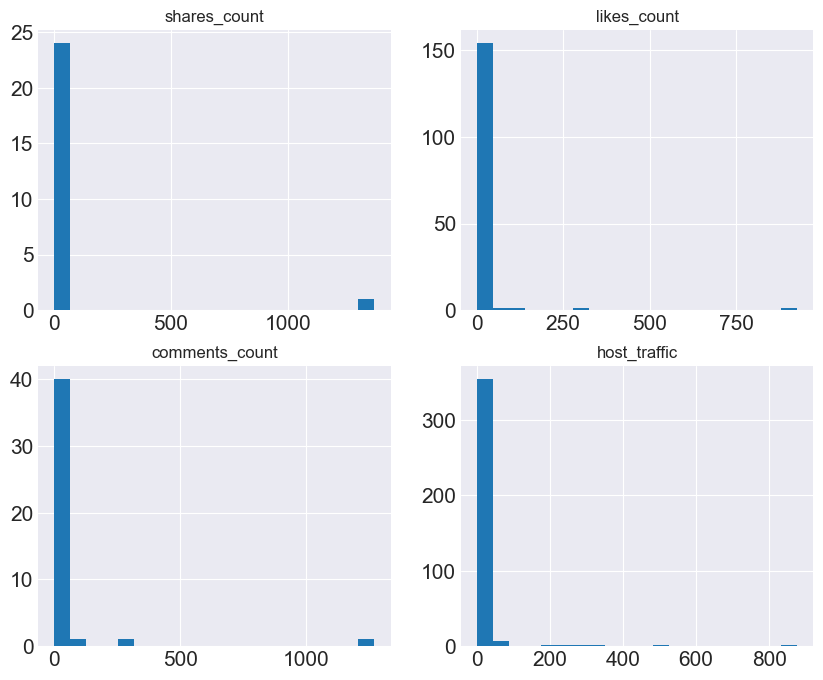

In [285]:
# from here we can understand that our data has high variance -> it's better not to use "mean" to fill NaN's
values_to_plot = ["shares_count", "likes_count", "comments_count", "host_traffic"]

fig = plt.figure()
fig.set_size_inches(10, 8)

for i in range(1, len(values_to_plot) + 1):
    fig.add_subplot(2, 2, i)
    value = values_to_plot[i - 1]
    plt.title(value)
    plt.hist(df[value].dropna().value_counts(), bins=20)

plt.show()

In [286]:
# Fill author_name with blank,because right now we will not need it during our analysis
df["author_name"].fillna("-", inplace=True)
df["title"].fillna("-", inplace=True)

# If data has no emotion -> we can assume that emotion of emoticon might be neutural -> = 0
df["emoticons"].fillna(0, inplace=True)

# Filling NaN values with medians
df["shares_count"].fillna(math.floor(df["shares_count"].median()), inplace=True)
df["likes_count"].fillna(math.floor(df["likes_count"].median()), inplace=True)
df["comments_count"].fillna(math.floor(df["comments_count"].median()), inplace=True)
df["host_traffic"].fillna(df["host_traffic"].median(), inplace=True)

# Filling with most frequent values
df["emotion"].fillna("neutral", inplace=True, axis=0)
df["intent"].fillna("UNDEFINED", inplace=True, axis=0)
df["sentiment"].fillna("neutral", inplace=True, axis=0)

# We will use day_of_year because it's more convenient
df["day_of_year"] = df["created_date"].dt.dayofyear

In [287]:
# Dealing with hashtags if hashatag == None;0;[] -> hashtag = mean(existing numberical values)
values_hashtags = [
    len(ast.literal_eval(row)) if isinstance(row, str) else 0 for row in df["hashtags"]
]
mean = int(np.floor(np.mean([value for value in values_hashtags if value > 0])))

df["hashtags"] = [mean if value == 0 else value for value in values_hashtags]

In [288]:
# Afterwards we create columns with number of full interactions
# You said that column emoticon may have some smiles of publications so it doesnt suit the purpose of counting interactions
df["num_of_interactions"] = df.loc[:, "shares_count":"comments_count"].sum(
    axis=1
)

df.drop(
    ["likes_count", "hashtags", "shares_count", "comments_count"], inplace=True, axis=1
)

In [289]:
# Filling NaN's with lemmas columns which are stemmed and lemmatized
def delete_punctuation(value):
    punctuation = string.punctuation
    without_punktuation = value.translate(str.maketrans("", "", punctuation))
    return without_punktuation

regex = re.compile("[^a-zA-Z]")
porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

lemmas = []

for content_ind in df["content"].index:
    content_in_ind = df.loc[content_ind, "content"]

    if type(df.loc[content_ind, "lemmas"]) == float:
        content = delete_punctuation(content_in_ind)
        nltk_tokens = nltk.word_tokenize(content)
        lemmatized_tokens = []

        for i in nltk_tokens:
            regex.sub("", i)

            if len(i) <= 3:
                continue
            lemmatized_tokens.append(lemmatizer.lemmatize(i))
    else:
        lemmatized_tokens = df.loc[content_ind, "lemmas"]
    lemmas.append(lemmatized_tokens)

df["lemmas"] = lemmas

In [290]:
# Created some dicts for different columns to convert emojies or mood to numerical values
marks_of_emojies = {
    "anger": -1,
    "anticipation": 0,
    "disgust": -1,
    "fear": -1,
    "joy": 1,
    "sadness": -1,
    "surprise": 0,
    "trust": 1,
}

mood_ratings_emotion = {
    "admiration": 1,
    "disgust": -1,
    "joy": 1,
    "sadness": -1,
    "anger": -1,
    "fear": -1,
    "neutral": 0,
}

sentiment_ratings = {"neutral": 0, "positive": 1, "negative": -1}

equivalent_emojis = {
    "🩷": "💗",
    "❤️": "💗",
    "☺️": "😄",
    "♥": "💗",
    "🥳": "🎉",
    "‼️": "❗",
    "🤣": "😂",
    "🥰": "💗",
    "🤍": "💗",
    "🧡": "💗",
    "🫶": "💗",
    "😑": "🤦",
}

In [291]:
# Dealing with imported dataset
df_emotions = df_emojies.iloc[:, 3:]

df_emotions = df_emotions.mul(marks_of_emojies)
df_emojies["mark"] = np.sum(df_emotions, axis=1) / 4

df_emojies.drop(
    ["trust", "anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise"],
    inplace=True,
    axis=1,
)

In [292]:
# converting emojies to numerical analog
emoji_score = []
for row in df["emoticons"]:
    if type(row) == str:
        row = ast.literal_eval(row)[0]

        if equivalent_emojis.get(row) != None:
            row = equivalent_emojis[row]

        score = df_emojies[df_emojies["emoji"] == row]["mark"].values
        if len(score) > 0:
            emoji_score.append(score[0])
        else:
            emoji_score.append(0)
    else:
        emoji_score.append(0)

df["emoji_mood"] = emoji_score

In [293]:
# Also working with emotions and sentiment columns(replacing with numerical values)
df["emotion_mood"] = df["emotion"]
df["sentiment_mood"] = df["sentiment"]

df["emotion_mood"].replace(mood_ratings_emotion, inplace=True)
df["sentiment_mood"].replace(sentiment_ratings, inplace=True)

df["mood"] = np.sum(df[["emoji_mood", "emotion_mood", "sentiment_mood"]], axis=1)
df.drop(["emoji_mood", "emotion_mood"], axis=1, inplace=True)


In [294]:
print(df.isna().any())

created_date           False
url                    False
title                  False
language               False
author_name            False
content                False
host                   False
host_traffic           False
emotion                False
sentiment              False
intent                 False
lemmas                 False
emoticons              False
country                False
ave                    False
reach                  False
day_of_year            False
num_of_interactions    False
sentiment_mood         False
mood                   False
dtype: bool


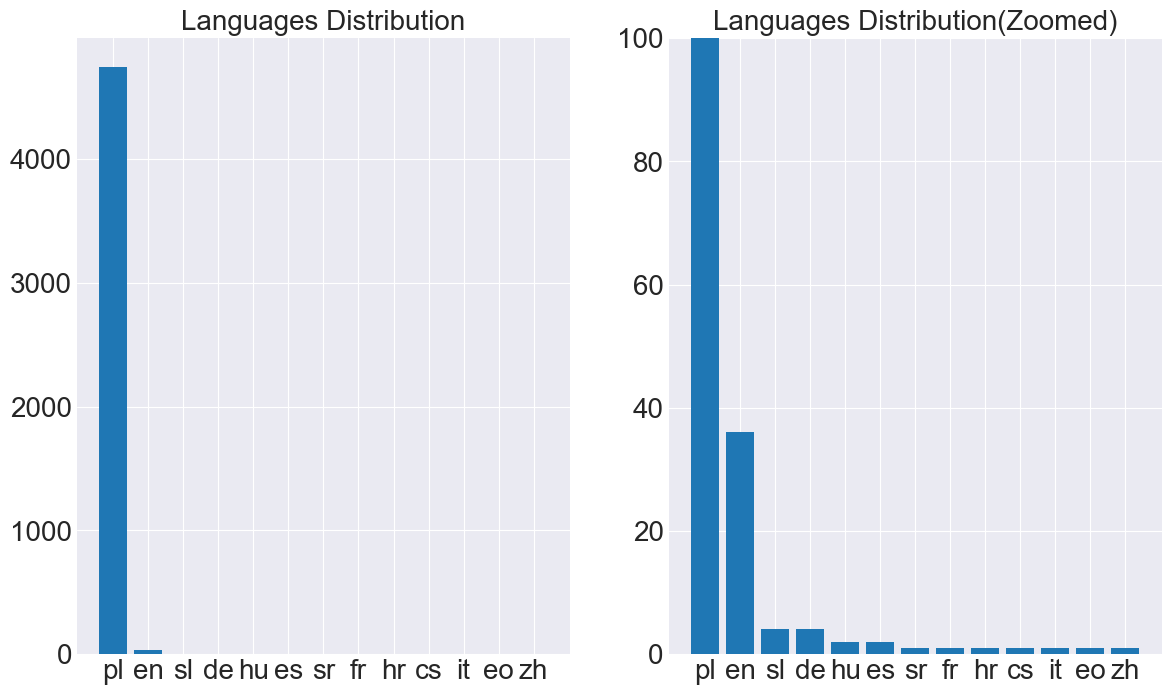

In [295]:
### QUESTION 1 ###
# Here we use bars to plot distribution of languages
values = df["language"].unique()
count = df["language"].value_counts().values

# Which languages are the most common
fig = plt.figure()
fig.set_size_inches(14, 8)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig.add_subplot(1, 2, 1)
plt.title("Languages Distribution",fontsize = 20)
plt.bar(values, height=count)

fig.add_subplot(1, 2, 2)
plt.title("Languages Distribution(Zoomed)",fontsize = 20)
plt.ylim(top=100)
plt.bar(values, height=count)
plt.show()

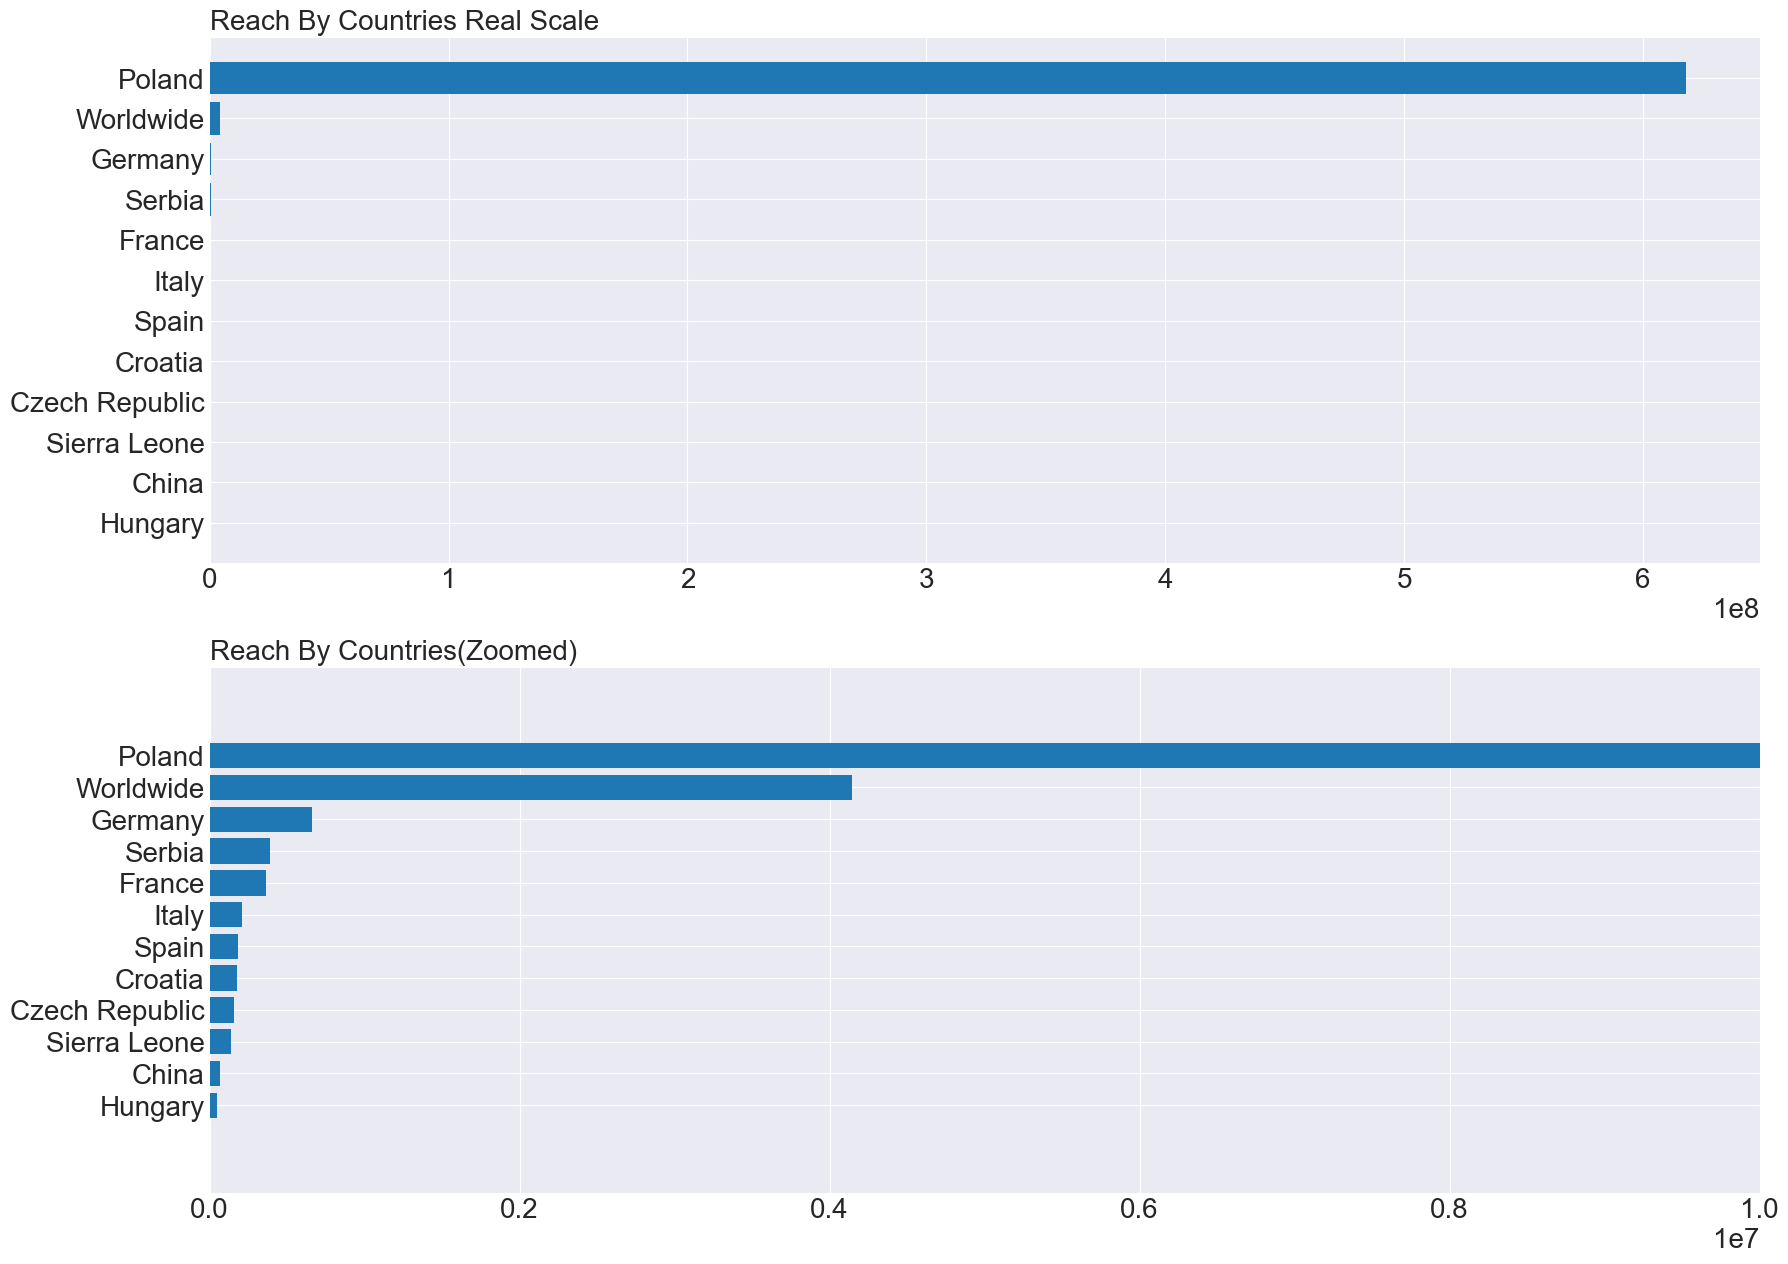

In [296]:
### QUESTION 2 ###
max_reach = df.groupby("country")["reach"].sum()

values = max_reach.index
count = max_reach.values

indexes = np.argsort(count)

fig = plt.figure()

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig.add_subplot(2, 1, 2)
fig.set_size_inches(20, 15)
plt.margins(0.2)
plt.xlim(right=10000000)
plt.title("Reach By Countries(Zoomed)", loc="left", fontsize = 20)
plt.barh(values[indexes], count[indexes])

fig.add_subplot(2, 1, 1)
fig.set_size_inches(20, 15)
plt.title("Reach By Countries Real Scale", loc="left", fontsize = 20)
plt.barh(values[indexes], count[indexes])

plt.show()

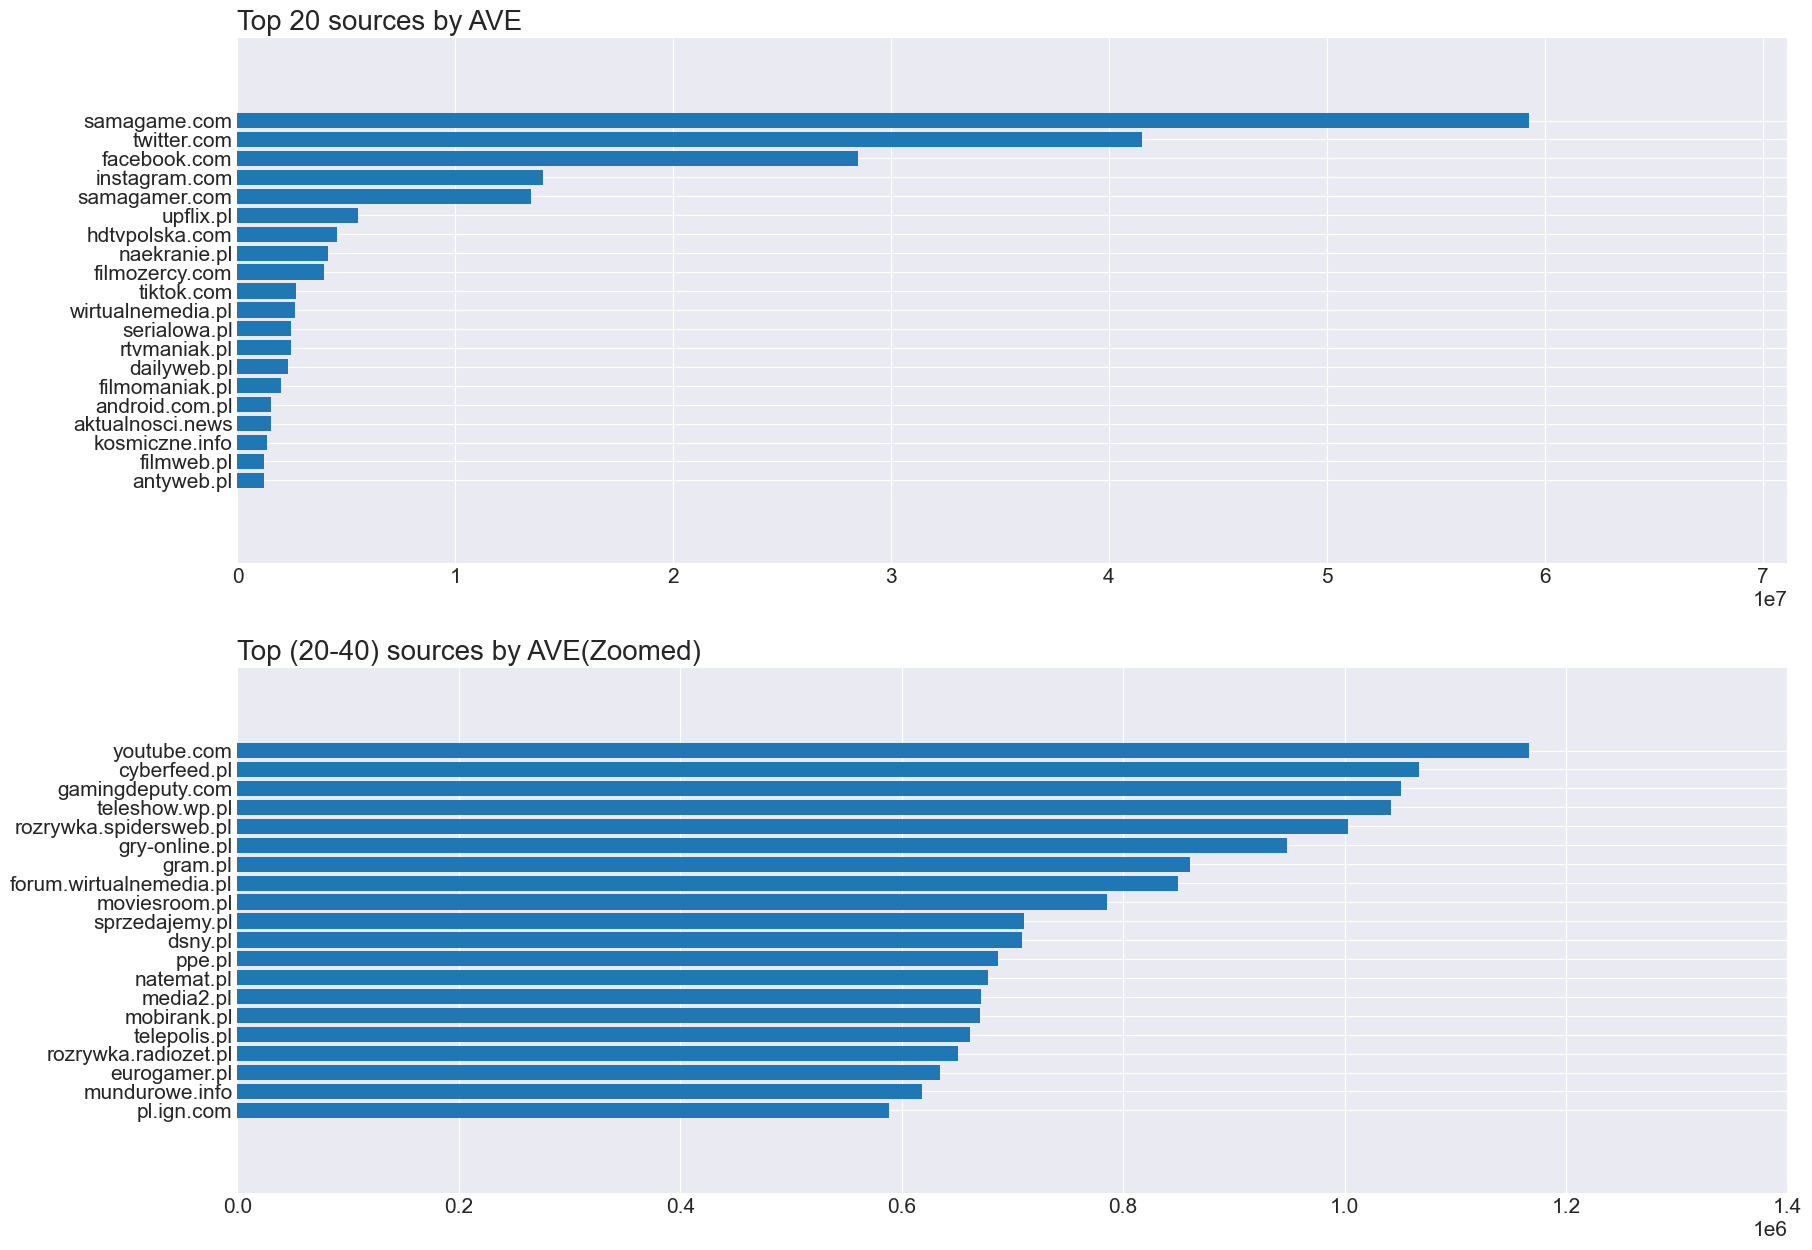

In [297]:
### QUESTION 3 ###
# We can replce "ROI" with "AVE" because :
# 1. We dont have Cost of Investment,Gross Return as columns so we can't really count "ROI".
# 2. "ROI" and "AVE" both reflect effectiveness of marketing company -> highly correlated -> to take top 20 most
# effective sources we can use AVE.
site_ave = df.groupby("host", sort=True)["ave"].sum()

values = site_ave.index
count = site_ave.values

indexes = np.argsort(count)

values_top_20 = values[indexes][-20:]
count_top_20 = count[indexes][-20:]

values_top_40 = values[indexes][-40:-20]
count_top_40 = count[indexes][-40:-20]

fig = plt.figure()
fig.set_size_inches(20, 15)

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

fig.add_subplot(2, 1, 1)
plt.margins(0.2)
plt.title("Top 20 sources by AVE",fontsize = 20,loc = "left")
plt.barh(values_top_20, count_top_20)

fig.add_subplot(2, 1, 2)
plt.margins(0.2)
plt.title("Top (20-40) sources by AVE(Zoomed)",fontsize = 20,loc = "left")
plt.barh(values_top_40, count_top_40)
plt.show()

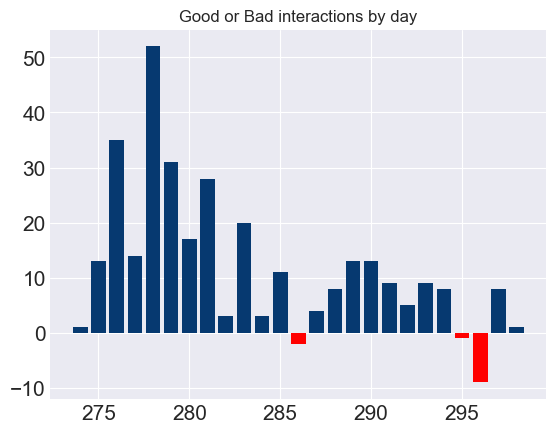

In [298]:
### QUESTION 4 ###
# Here we can see on which day of 2023 sentiment mood is rather bad than good
max_reach = df.groupby("day_of_year")["sentiment_mood"].sum()

negative_days = max_reach[max_reach.values < 0].index

values = max_reach.index
count = max_reach.values

max_reach = pd.Series(max_reach.values > 0)
colors = max_reach.map({True: '#063970', False: 'r'})

fig.set_size_inches(10, 8)
plt.title("Good or Bad interactions by day")
plt.bar(values, count, color = colors)
plt.show()

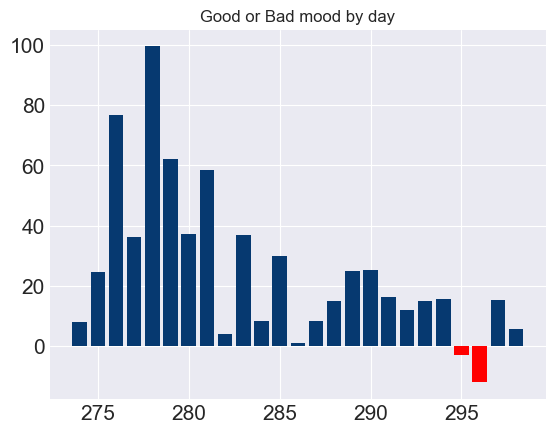

In [299]:
### QUESTION 4 ###
# Here i tried to use metric which i creates(sum emotion,sentiment and emoticons)
# But it didnt see day 286 -> emoticons are not so useful due to ambiguity and because too much NaNs(most of them)
# So replacing NaN's with 0 just putted bad comments with no emojies higher.But if we will have less NaN's or
# trained word tokenizer(like Word2Vec) also on emojies - may be a good idea.

max_reach = df.groupby("day_of_year")["mood"].sum()

values = max_reach.index
count = max_reach.values

max_reach = pd.Series(max_reach.values > 0)
colors = max_reach.map({True: '#063970', False: 'r'})

fig.set_size_inches(10, 8)
plt.title("Good or Bad mood by day")
plt.bar(values, count, color = colors)
plt.show()

In [300]:
# Printing out comments for each negative day
for day in negative_days:
    df_neg = df[(df["day_of_year"] == day) & (df["sentiment"] == "negative")]

    if not df_neg.empty:
        print(
            f"Day is {day} ({df_neg['created_date'].dt.date.iloc[0]}) and comments are:"
        )
        titles = df_neg["title"].values
        filtered_titles = [title for title in titles if title != "-"]
        print("\n".join(filtered_titles))
        print("--------")

#  Luckily we have only 3 days
#  day 286 : We have most of the comments like this : "Mam takie dziwne wrażenie,
#  jakby brakowało odcinka miedzy pierwszym i drugim." -> Disney+ missed second episode of Loky
#  day 295 : Everything is ok, just a lot of comments about films(simple coincidition)
#  day 296 : Problem with application (Software problems -> just didn't worked or worked with some issues)

Day is 286 (2023-10-13) and comments are:
Ahsoka/Disney+ Recenzja Naprawdę szkoda, że \&quot;Rebelianci\&quot; nie dostali kontynuacji w formie animacji... Filoni umie w animacje co udowodnił niejednok...
Dlaczego usuwacie komentarze ?? Sól w oku zapiekła??
Ktoś wie jak się skontaktować z Disney+ (nie licząc tego zagranicznego numery telefonu że strony). Nie mogę znaleźć ani maila, ani czatu.
Duchy Inirsherin (The Banshees of Inisherin) 2022 reż. Martin McDonagh Filmweb: 7,5/10 IMDb: 7,7/10 Rottentomatoes: 96% Moja ocena: 8/10 Choć nie w...
Marcin Wawrzyniak Dokładnie, brakuje 2 odcinka. Na oficjalnej stronie Disney+ reklamują, że jest dzisiaj do obejrzenia 3 odcinek.
Marek Machel Dokładnie, brakuje 2 odcinka. Na oficjalnej stronie Disney+ reklamują, że jest dzisiaj do obejrzenia 3 odcinek.
Disney+ Nie chcę mówić, ale brakuje 2 odcinka Lokiego. Wy reklamujecie, że jest 3 odcinek do obejrzenia, a na platformie są tylko dwa odcinki z czego ...
Mam takie dziwne wrażenie, jakby brakowało o